In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os 
from datetime import datetime
import seaborn as sn
import pandas as pd

# show all the output 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Step1: Define Help Functions:

### 1. Help Fucntions for Downloading and Importing Data

In [2]:
# %load ./cifar10.py
########################################################################
#
# Functions for downloading the CIFAR-10 data-set from the internet
# and loading it into memory.
#
# Implemented in Python 3.5
#
# Usage:
# 1) Set the variable data_path with the desired storage path.
# 2) Call maybe_download_and_extract() to download the data-set
#    if it is not already located in the given data_path.
# 3) Call load_class_names() to get an array of the class-names.
# 4) Call load_training_data() and load_test_data() to get
#    the images, class-numbers and one-hot encoded class-labels
#    for the training-set and test-set.
# 5) Use the returned data in your own program.
#
# Format:
# The images for the training- and test-sets are returned as 4-dim numpy
# arrays each with the shape: [image_number, height, width, channel]
# where the individual pixels are floats between 0.0 and 1.0.
#
########################################################################
#
# This file is part of the TensorFlow Tutorials available at:
#
# https://github.com/Hvass-Labs/TensorFlow-Tutorials
#
# Published under the MIT License. See the file LICENSE for details.
#
# Copyright 2016 by Magnus Erik Hvass Pedersen
#
########################################################################

import numpy as np
import pickle
import os
import urllib.request
import tarfile
import zipfile

########################################################################

# Directory where you want to download and save the data-set.
# Set this before you start calling any of the functions below.
data_path = "data/CIFAR-10/"

# URL for the data-set on the internet.
data_url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"

########################################################################
# Various constants for the size of the images.
# Use these constants in your own program.

# Width and height of each image.
img_size = 32

# Number of channels in each image, 3 channels: Red, Green, Blue.
num_channels = 3

# Length of an image when flattened to a 1-dim array.
img_size_flat = img_size * img_size * num_channels

# Number of classes.
num_classes = 10

########################################################################
# Various constants used to allocate arrays of the correct size.

# Number of files for the training-set.
_num_files_train = 5

# Number of images for each batch-file in the training-set.
_images_per_file = 10000

# Total number of images in the training-set.
# This is used to pre-allocate arrays for efficiency.
_num_images_train = _num_files_train * _images_per_file

########################################################################
# Private functions for downloading, unpacking and loading data-files.


def _get_file_path(filename=""):
    """
    Return the full path of a data-file for the data-set.
    If filename=="" then return the directory of the files.
    """

    return os.path.join(data_path, "cifar-10-batches-py/", filename)


def _unpickle(filename):
    """
    Unpickle the given file and return the data.
    Note that the appropriate dir-name is prepended the filename.
    """

    # Create full path for the file.
    file_path = _get_file_path(filename)

    print("Loading data: " + file_path)

    with open(file_path, mode='rb') as file:
        # In Python 3.X it is important to set the encoding,
        # otherwise an exception is raised here.
        data = pickle.load(file, encoding='bytes')

    return data

def ZCAtrans(raw):
    xm = np.mean(raw, axis = 0)
    raw= raw- xm
    raw2 = raw.reshape((raw.shape[0], -1))
    # raw is assumed to be zero-mean
    C = np.dot( raw2.T, raw2 )/raw2.shape[0]
    U, eva, V = np.linalg.svd(C)  # U[:, i] is the i-th eigenvector
    sqeva = np.sqrt(eva + 0.001)
    Uzca = np.dot(U/sqeva[np.newaxis, :], U.T)
    X = np.dot(raw2, Uzca)
    return X

def _convert_images(raw):
    """
    Convert images from the CIFAR-10 format and
    return a 4-dim array with shape: [image_number, height, width, channel]
    where the pixels are floats between 0.0 and 1.0.
    """

    # Convert the raw images from the data-files to floating-points.
    raw_float = np.array(raw, dtype=float) / 255.0
    raw_float = ZCAtrans(raw_float)

    # Reshape the array to 4-dimensions.
    images = raw_float.reshape([-1, num_channels, img_size, img_size])

    # Reorder the indices of the array.
    images = images.transpose([0, 2, 3, 1])
    
    # normailze each image
    for i in range(images.shape[0]):
        m,M = images[i].min(), images[i].max()
        images[i]=(images[i] - m) / (M - m)

    return images


def _load_data(filename):
    """
    Load a pickled data-file from the CIFAR-10 data-set
    and return the converted images (see above) and the class-number
    for each image.
    """

    # Load the pickled data-file.
    data = _unpickle(filename)

    # Get the raw images.
    raw_images = data[b'data']

    # Get the class-numbers for each image. Convert to numpy-array.
    cls = np.array(data[b'labels'])

    # Convert the images.
    images = _convert_images(raw_images)

    return images, cls


########################################################################
# Public functions that you may call to download the data-set from
# the internet and load the data into memory.


def maybe_download_and_extract(url, download_dir):
    """
    Download and extract the data if it doesn't already exist.
    Assumes the url is a tar-ball file.

    :param url:
        Internet URL for the tar-file to download.
        Example: "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"

    :param download_dir:
        Directory where the downloaded file is saved.
        Example: "data/CIFAR-10/"

    :return:
        Nothing.
    """

    # Filename for saving the file downloaded from the internet.
    # Use the filename from the URL and add it to the download_dir.
    filename = url.split('/')[-1]
    file_path = os.path.join(download_dir, filename)

    # Check if the file already exists.
    # If it exists then we assume it has also been extracted,
    # otherwise we need to download and extract it now.
    if not os.path.exists(file_path):
        # Check if the download directory exists, otherwise create it.
        if not os.path.exists(download_dir):
            os.makedirs(download_dir)

        # Download the file from the internet.
        file_path, _ = urllib.request.urlretrieve(url=url,
                                                  filename=file_path,
                                                  reporthook=_print_download_progress)

        print()
        print("Download finished. Extracting files.")

        if file_path.endswith(".zip"):
            # Unpack the zip-file.
            zipfile.ZipFile(file=file_path, mode="r").extractall(download_dir)
        elif file_path.endswith((".tar.gz", ".tgz")):
            # Unpack the tar-ball.
            tarfile.open(name=file_path, mode="r:gz").extractall(download_dir)

        print("Done.")
    else:
        print("Data has apparently already been downloaded and unpacked.")



def load_class_names():
    """
    Load the names for the classes in the CIFAR-10 data-set.
    Returns a list with the names. Example: names[3] is the name
    associated with class-number 3.
    """

    # Load the class-names from the pickled file.
    raw = _unpickle(filename="batches.meta")[b'label_names']

    # Convert from binary strings.
    names = [x.decode('utf-8') for x in raw]

    return names

def one_hot_encoded(class_numbers, num_classes=None):
    """
    Generate the One-Hot encoded class-labels from an array of integers.
    For example, if class_number=2 and num_classes=4 then
    the one-hot encoded label is the float array: [0. 0. 1. 0.]
    :param class_numbers:
        Array of integers with class-numbers.
        Assume the integers are from zero to num_classes-1 inclusive.
    :param num_classes:
        Number of classes. If None then use max(class_numbers)+1.
    :return:
        2-dim array of shape: [len(class_numbers), num_classes]
    """

    # Find the number of classes if None is provided.
    # Assumes the lowest class-number is zero.
    if num_classes is None:
        num_classes = np.max(class_numbers) + 1

    return np.eye(num_classes, dtype=float)[class_numbers]

def load_training_data():
    """
    Load all the training-data for the CIFAR-10 data-set.
    The data-set is split into 5 data-files which are merged here.
    Returns the images, class-numbers and one-hot encoded class-labels.
    """

    # Pre-allocate the arrays for the images and class-numbers for efficiency.
    images = np.zeros(shape=[_num_images_train, img_size, img_size, num_channels], dtype=float)
    cls = np.zeros(shape=[_num_images_train], dtype=int)

    # Begin-index for the current batch.
    begin = 0

    # For each data-file.
    for i in range(_num_files_train):
        # Load the images and class-numbers from the data-file.
        images_batch, cls_batch = _load_data(filename="data_batch_" + str(i + 1))

        # Number of images in this batch.
        num_images = len(images_batch)

        # End-index for the current batch.
        end = begin + num_images

        # Store the images into the array.
        images[begin:end, :] = images_batch

        # Store the class-numbers into the array.
        cls[begin:end] = cls_batch

        # The begin-index for the next batch is the current end-index.
        begin = end

    return images, cls, one_hot_encoded(class_numbers=cls, num_classes=num_classes)


def load_test_data():
    """
    Load all the test-data for the CIFAR-10 data-set.
    Returns the images, class-numbers and one-hot encoded class-labels.
    """

    images, cls = _load_data(filename="test_batch")

    return images, cls, one_hot_encoded(class_numbers=cls, num_classes=num_classes)

########################################################################
## The following is for loading testing data to show the original images
#######################################################################

def _convert_images_for_print(raw):
    """
    Convert images from the CIFAR-10 format and
    return a 4-dim array with shape: [image_number, height, width, channel]
    where the pixels are floats between 0.0 and 1.0.
    """

    # Convert the raw images from the data-files to floating-points.
    raw_float = np.array(raw, dtype=float) / 255.0

    # Reshape the array to 4-dimensions.
    images = raw_float.reshape([-1, num_channels, img_size, img_size])

    # Reorder the indices of the array.
    images = images.transpose([0, 2, 3, 1])

    return images


def _load_data_for_print(filename):
    """
    Load a pickled data-file from the CIFAR-10 data-set
    and return the converted images (see above) and the class-number
    for each image.
    """

    # Load the pickled data-file.
    data = _unpickle(filename)

    # Get the raw images.
    raw_images = data[b'data']

    # Get the class-numbers for each image. Convert to numpy-array.
    cls = np.array(data[b'labels'])

    # Convert the images.
    images = _convert_images_for_print(raw_images)

    return images, cls

def load_test_data_for_print():
    """
    Load all the test-data for the CIFAR-10 data-set.

    Returns the images, class-numbers and one-hot encoded class-labels.
    """

    images, cls = _load_data_for_print(filename="test_batch")

    return images, cls, one_hot_encoded(class_numbers=cls, num_classes=num_classes)


### 2. Help Fucntions for Data Augmentation

In [3]:
# %load ./Augmentation.py
########################################################################
## The function is for data Augmentation:
########################################################################
def pre_process_image(image, training):
    # This function takes a single image as input,
    # and a boolean whether to build the training or testing graph.
    
    if training:
        # For training, add the following to the TensorFlow graph.

        # Randomly crop the input image.
        image = tf.random_crop(image, size=[img_size_cropped, img_size_cropped, num_channels])

        # Randomly flip the image horizontally.
        image = tf.image.random_flip_left_right(image)
        
        # Randomly adjust hue, contrast and saturation.
        image = tf.image.random_hue(image, max_delta=0.05)
        image = tf.image.random_contrast(image, lower=0.3, upper=1.0)
        image = tf.image.random_brightness(image, max_delta=0.2)
        image = tf.image.random_saturation(image, lower=0.0, upper=2.0)

        # Some of these functions may overflow and result in pixel
        # values beyond the [0, 1] range. It is unclear from the
        # documentation of TensorFlow 0.10.0rc0 whether this is
        # intended. A simple solution is to limit the range.

        # Limit the image pixels between [0, 1] in case of overflow.
        image = tf.minimum(image, 1.0)
        image = tf.maximum(image, 0.0)
    else:
        # For training, add the following to the TensorFlow graph.

        # Crop the input image around the centre so it is the same
        # size as images that are randomly cropped during training.
        image = tf.image.resize_image_with_crop_or_pad(image,
                                                       target_height=img_size_cropped,
                                                       target_width=img_size_cropped)

    return image

##########################################################
## The function is for apply preprocessiong for all images:
##########################################################
def pre_process(images, training):
    # Use TensorFlow to loop over all the input images and call
    # the function above which takes a single image as input.
    images = tf.map_fn(lambda image: pre_process_image(image, training), images)

    return images

### 3. Help Function for Bulding CNN

In [4]:
# %load ./CNN.py
#######################################################
# The function is for compute the cross entropy
#######################################################
def compute_cross_entropy(logits, y):
    sm_ce = tf.nn.softmax_cross_entropy_with_logits(labels=y,logits=logits, name='cross_ent_terms')
    cross_ent = tf.reduce_mean(sm_ce, name='cross_ent')
    return cross_ent


#######################################################
# The function is for compute the cross entropy
#######################################################
def compute_accuracy(logits, y):
    prediction = tf.argmax(logits, 1, name='pred_class')
    true_label = tf.argmax(y, 1, name='true_class')
    accuracy = tf.reduce_mean(tf.cast(tf.equal(prediction, true_label), tf.float32))
    return  prediction, accuracy

#######################################################
# The function is for geting random batch for training the network
#######################################################
def random_batch():
    # Number of images in the training-set.
    num_images = len(images_train)
    
    # Create a random index.
    idx = np.random.choice(num_images,
                           size=batch_size,
                           replace=False)

    # Use the random index to select random images and labels.
    x_batch = images_train[idx,:,:,:]
    y_batch = labels_train[idx, :]

    return x_batch, y_batch

######################################################
# The Function for defineing the CNN Network
######################################################
# Inference

def _variable_with_weight_decay(name, shape, stddev, wd):
    """
    Helper to create an initialized Variable with weight decay

    Args:
        name: name of the variable
        shape: list of ints
        stddev: standard deviation of a truncated Gaussian
        wd: add L2Loss weight decay multiplied by this float. If None, weight
            decay is not added for this Variable.

    Returns:
        Variable Tensor
    """
    var = _variable_on_cpu(
        name,
        shape,
        tf.truncated_normal_initializer(stddev=stddev, dtype=tf.float32))
    if wd is not None:
        weight_decay = tf.multiply(tf.nn.l2_loss(var), wd, name='weight_loss')
        tf.add_to_collection('losses', weight_decay)
    return var


def _variable_on_cpu(name, shape, initializer):
    """
    Helper to create a Variable stored on CPU memory

    Args:
        name: name of the variable
        shape: list of ints
        initializer: initializer for Variable

    Returns:
        Variable Tensor

    """
    with tf.device('/cpu:0'):
        var = tf.get_variable(name, shape, initializer=initializer, dtype=tf.float32)
    return var

def compute_logits_cnn(x):
    
    phase_train = tf.placeholder(tf.bool, name='phase_train')

    x = tf.reshape(x, [-1, img_size_cropped, img_size_cropped, 3])

    # layer_conv1
    with tf.variable_scope('conv1') as scope:
        kernel = _variable_with_weight_decay('weights',
                                             shape=[5, 5, 3, 64],
                                             stddev=5e-2,
                                             wd=0.0)
        conv = tf.nn.conv2d(images, kernel, [1, 1, 1, 1], padding='SAME')
        biases = _variable_on_cpu('biases', [64], tf.constant_initializer(0.0))
        pre_activation = tf.nn.bias_add(conv, biases)
        conv1 = tf.nn.relu(pre_activation, name=scope.name)

    # max_pool
    pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                         padding='SAME', name='pool1')

    # layer_conv2
    with tf.variable_scope('conv2') as scope:
        kernel = _variable_with_weight_decay('weights',
                                             shape=[5, 5, 64, 64],
                                             stddev=5e-2,
                                             wd=0.0)
        conv = tf.nn.conv2d(pool1, kernel, [1, 1, 1, 1], padding='SAME')
        biases = _variable_on_cpu('biases', [64], tf.constant_initializer(0.0))
        pre_activation = tf.nn.bias_add(conv, biases)
        conv2 = tf.nn.relu(pre_activation, name=scope.name) 

    # max_pool
    pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                         padding='SAME', name='pool1')
    
    # layer_fc1
    with tf.variable_scope('fc1') as scope:
        # flatten
        reshape = tf.reshape(pool2, [-1, 6*6*64])
        dim = reshape.get_shape()[1].value
        weights = _variable_with_weight_decay('weights', shape=[dim, 256],
                                              stddev=0.04, wd=0.0)
        biases = _variable_on_cpu('biases', [256], tf.constant_initializer(0.0))
        fc1 = tf.nn.relu(tf.matmul(reshape, weights) + biases, name=scope.name)

    # layer_fc2
    with tf.variable_scope('fc2') as scope:
        weights = _variable_with_weight_decay('weights', shape=[256, 128],
                                              stddev=0.04, wd=0.0)
        biases = _variable_on_cpu('biases', [128], tf.constant_initializer(0.0))
        fc2 = tf.nn.relu(tf.matmul(fc1, weights) + biases, name=scope.name)

    # softmax_classifier
    with tf.variable_scope('softmax_linear') as scope:
        weights = _variable_with_weight_decay('weights', [128, num_classes],
                                          stddev=1/128.0, wd=0.0)
        biases = _variable_on_cpu('biases', [num_classes],
                              tf.constant_initializer(0.0))
        softmax_linear = tf.add(tf.matmul(fc2, weights), biases, name=scope.name)   

    return softmax_linear, pool1 , pool2

### 4. Help Function for Building Network in Network

In [5]:
# %load ./NIN.py
#######################################################
# The funciton is for building Network in Network.
#######################################################
def conv(x, W):
    """simple wrapper for tf.nn.conv2d"""
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def maxpool(x):
    """simple wrapper for tf.nn.max_pool with kernel size 3, stride size 2"""
    return tf.nn.max_pool(x, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding='SAME')

def avgpool(x, k = 3, s = 2, p = 'SAME'):
    """simple wrapper for tf.nn.max_pool with kernel size 3, stride size 2"""
    return tf.nn.avg_pool(x, ksize=[1, k, k, 1], strides=[1, s, s, 1], padding= p)

def dropout(x):
    """simple wrapper for tf.nn.dropout with dropout ratio 0.5"""
    return tf.nn.dropout(x, 0.5)

## Define the Network
def compute_logits_NIN(x):
    x_image = tf.reshape(x, [-1, img_size_cropped, img_size_cropped, 3])
    # conv1 / relu1
    W_conv1 = tf.get_variable('W_conv1', shape = [5, 5, 3, 192])
    b_conv1 = tf.get_variable('b_conv1', shape = [192],)
    h_conv1 = tf.nn.relu(tf.add(conv(x_image, W_conv1), b_conv1))
    
    # cccp1 / relu_cccp1
    W_cccp1 = tf.get_variable('W_cccp1', shape = [1, 1, 192, 160])
    b_cccp1 = tf.get_variable('b_cccp1', shape = [160])
    h_cccp1 = tf.nn.relu(tf.add(conv(h_conv1, W_cccp1), b_cccp1))
    
    # cccp2 / relu_cccp2
    W_cccp2 = tf.get_variable('W_cccp2', shape = [1, 1, 160, 96])
    b_cccp2 = tf.get_variable('b_cccp2', shape = [96])
    h_cccp2 = tf.nn.relu(tf.add(conv(h_cccp1, W_cccp2), b_cccp2))
    
    #print(h_cccp2)
    h_pool1 = maxpool(h_cccp2)
    # drop3
    h_drop3 = dropout(h_pool1)
    # conv2 / relu2
    W_conv2 = tf.get_variable('W_conv2', shape = [5, 5, 96, 192])
    b_conv2 = tf.get_variable('b_conv2',shape = [192])
    h_conv2 = tf.nn.relu(tf.add(conv(h_drop3, W_conv2), b_conv2))
    
    # cccp3 / relu_cccp3
    W_cccp3 = tf.get_variable('W_cccp3', shape = [1, 1, 192, 192])
    b_cccp3 = tf.get_variable('b_cccp3', shape = [192])
    h_cccp3 = tf.nn.relu(tf.add(conv(h_conv2, W_cccp3), b_cccp3))
    
    # cccp4 / relu_cccp4
    W_cccp4 = tf.get_variable('W_cccp4', shape = [1, 1, 192, 192])
    b_cccp4 = tf.get_variable('b_cccp4',shape = [192])
    h_cccp4 = tf.nn.relu(tf.add(conv(h_cccp3, W_cccp4), b_cccp4))
    # poo2
    h_pool2 = avgpool(h_cccp4)
    # drop6
    h_drop6 = dropout(h_pool2)
    
    # conv3 / relu3
    W_conv3 = tf.get_variable('W_conv3', shape = [3, 3, 192, 192])
    b_conv3 = tf.get_variable('b_conv3',shape = [192],)
    h_conv3 = tf.nn.relu(tf.add(conv(h_drop6, W_conv3), b_conv3))
    
    # cccp5 / relu_cccp5
    W_cccp5 = tf.get_variable('W_cccp5', shape = [1, 1, 192, 192])
    b_cccp5 = tf.get_variable('b_cccp5', shape = [192])
    h_cccp5 = tf.nn.relu(tf.add(conv(h_conv3, W_cccp5), b_cccp5))
    
    # cccp6 / relu_cccp6
    W_cccp6 = tf.get_variable('W_cccp6', shape = [1, 1, 192, 10])
    b_cccp6 = tf.get_variable('b_cccp6',shape = [10])
    h_cccp6 = tf.nn.relu(tf.nn.bias_add(conv(h_cccp5, W_cccp6), b_cccp6))
    
    # pool3
    h_pool3 = avgpool(h_cccp6, 6, 1, 'VALID')
    output_reshaped = tf.reshape(h_pool3, [-1,10])

    return output_reshaped,h_conv1,h_cccp1,h_cccp2,h_pool1,h_conv2,h_pool2,h_cccp3,h_cccp4,h_conv3,h_cccp5,h_cccp6,h_pool3

###########################################################
#############################################################

### 5. Help Function for Network Visulization and Model Evaluation

In [6]:
# %load ./Visulization.py
########################################################################
# The functions are for showing the original images
########################################################################
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true) == 9
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing if we need to print ensemble and best-net.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Interpolation type.
        if smooth:
            interpolation = 'spline16'
        else:
            interpolation = 'nearest'

        # Plot image.
        ax.imshow(images[i, :, :, :],
                  interpolation=interpolation)
            
        # Name of the true class.
        cls_true_name = class_names[cls_true[i]]

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true_name)
        else:
            # Name of the predicted class.
            cls_pred_name = class_names[cls_pred[i]]

            xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()


########################################################################
# The functions are for showing different layer for the networks
########################################################################
def getActivations(sess,layer_name,image_name):
    units = sess.run(layer_name,feed_dict={x:image_name})
    plotNNFilter(units)
    
    
def plotNNFilter(units):
    filters = units.shape[3]
    plt.figure(1, figsize=(20,20))
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(units[0,:,:,i], interpolation="nearest", cmap="gray")

#######################################################
# The function is for obtaining hard assignment for the images and show the confusion matrix
#######################################################
def Test_Anlaysis(sess, images, labels, cls_true):
    
    num_images = len(images)
    # Initialize the predictions
    cls_pred = np.zeros(shape=num_images, dtype=np.int)
    
    i = 0
    while i < num_images:
        # The ending index for the next batch is denoted j.
        j = min(i + batch_size, num_images)
        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = sess.run(prediction, feed_dict={x: images[i:j, :],y_true: labels[i:j, :]})

        # end-index of the current batch.
        i = j
    
    co_ma = confusion_matrix(y_true=cls_true, y_pred=cls_pred) 
    
    # Print the confusion matrix as text.
    print("Confusion Matrix as numbers:")  
    for i in range(num_classes):
        # Append the class-name to each line.
        class_name = "({}) {}".format(i, class_names[i])
        print(co_ma[i, :], class_name)
    
    # Print the consusion matrix as graph
    print("Plot Confusion Matrix:")  
    df_cm = pd.DataFrame(co_ma, index = [i for i in class_names],
                  columns = [i for i in class_names])
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)


## 2. Download and Import Data

In [7]:
maybe_download_and_extract(url=data_url, download_dir=data_path)

Data has apparently already been downloaded and unpacked.


In [8]:
# show the labels
class_names = load_class_names()
class_names
# show bisic property of the dta set
img_size
num_channels
num_classes

Loading data: data/CIFAR-10/cifar-10-batches-py/batches.meta


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

32

3

10

In [9]:
# Load Data to see the original images
images_test_for_print, cls_test_for_print, labels_test_for_print = load_test_data_for_print()

Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch


**Show the original image**

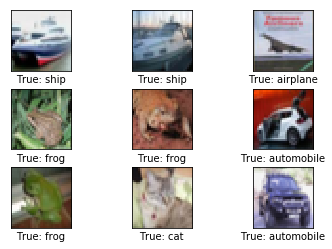

In [10]:
plot_images(images_test_for_print[1:10,:,:,:],cls_test_for_print[1:10], cls_pred=None, smooth=False)

In [11]:
images_train, cls_train, labels_train = load_training_data()
images_test, cls_test, labels_test = load_test_data()

Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5
Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch


In [12]:
images_train2 = images_train
images_test2 = images_test
labels_train2 = labels_train
labels_test2 = labels_test

In [13]:
images_train = images_train[0:100,:,:,:]
images_test = images_test[0:100,:,:,:]
labels_train = labels_train[0:100,:]
labels_test = labels_test[0:100,:]

In [14]:
# Check the data shape 
images_train.shape
images_test.shape
labels_train.shape   ##label_train and test_train is the one-hot coded label 
labels_test.shape

(100, 32, 32, 3)

(100, 32, 32, 3)

(100, 10)

(100, 10)

**Show the images after preprocessing**

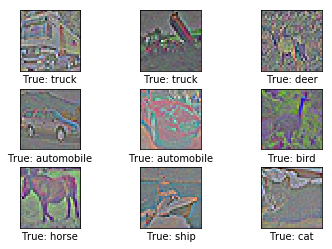

In [15]:
plot_images(images_train[1:10,:,:,:], cls_train[1:10], cls_pred=None, smooth=False)

## 3. Train the CNN Garph

In [19]:
# TRAIN
now = datetime.now()
dir_name = './CNN/log_{0}_{1}'.format(now.month,now.day)
export_dir = './CNN/savedmodel_{0}_{1}_{2}_{3}'.format(now.month,now.day,now.hour,now.second)
img_size_cropped = 24

batch_size = 10
num_iterations = 100
opt_method = 'adam'
print_unit = 100
learning_rate = 1e-4

In [20]:
builder = tf.saved_model.builder.SavedModelBuilder(export_dir)
with tf.Graph().as_default():
    global_step = tf.train.get_or_create_global_step()

    with tf.device('/cpu:0'):
        x = tf.placeholder(tf.float32, shape=[None, 32, 32, num_channels], name='x')
        y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

        images = pre_process(images=x, training=True)

        with tf.name_scope('model'):
            logits, pool1_cnn, pool2_cnn = compute_logits_cnn(images)

        with tf.name_scope('loss'):
            loss = compute_cross_entropy(logits=logits, y=y_true)

        with tf.name_scope('accuracy'):
            prediction,accuracy = compute_accuracy(logits=logits, y=y_true)

        with tf.name_scope('opt'):
            opt = tf.train.AdamOptimizer(learning_rate)
            train_step = opt.minimize(loss)

        with tf.name_scope('summaries'):
            tf.summary.scalar('loss', loss)
            tf.summary.scalar('accuracy', accuracy)
            tf.summary.histogram('logit', logits)
            tf.summary.image('input', tf.reshape(images, [-1, img_size_cropped, img_size_cropped, num_channels]))
            summary_op = tf.summary.merge_all()

        saver = tf.train.Saver()

        sess2 = tf.Session()
        summary_writer = tf.summary.FileWriter(dir_name, sess2.graph)
        summary_writer_train = tf.summary.FileWriter(dir_name+'/train', sess2.graph)
        summary_writer_val = tf.summary.FileWriter(dir_name+'/val')

        try:
            print("Trying to restore last checkpoint ...")

            # Use TensorFlow to find the latest checkpoint - if any.
            last_chk_path = tf.train.latest_checkpoint(checkpoint_dir='./CNN/model/')

            # Try and load the data in the checkpoint.
            saver.restore(sess2, save_path=last_chk_path)

            # If we get to this point, the checkpoint was successfully loaded.
            print("Restored checkpoint from:", last_chk_path)
        except:
            # If the above failed for some reason, simply
            # initialize all the variables for the TensorFlow graph.
            print("Failed to restore checkpoint. Initializing variables instead.")
            sess2.run(tf.global_variables_initializer())

        for i in range(num_iterations):

            X_batch, y_batch = random_batch()

            _, summary = sess2.run((train_step, summary_op),
                                    feed_dict={x: X_batch, y_true: y_batch})

            if i%print_unit==0:
                summary_writer_train.add_summary(summary, i)

                (train_error, train_accuracy, train_logits) = sess2.run((loss, accuracy, logits), {x: X_batch, y_true: y_batch})
                print("\rStep {0:3d}: training accuracy {1:0.4f}".format(i, train_accuracy), flush=True)
                print("\rStep {0:3d}: training loss {1:0.4f}".format(i, train_error), flush=True)

                (val_error, val_accuracy, summary) = sess2.run((loss, accuracy,summary_op), {x:images_test, y_true:labels_test})
                print("\rStep {0:3d}: val accuracy {1:0.4f}".format(i, val_accuracy), flush=True)
                print("\rStep {0:3d}: val loss {1:0.4f}".format(i, val_error), flush=True)
                summary_writer_val.add_summary(summary, i)
                saver.save(sess2, './CNN/model/model_iter', global_step=i)

        save_path = saver.save(sess2, "./CNN/model/final_model.ckpt")
        builder.add_meta_graph_and_variables(sess2, ["foo-tag"])

builder.save()

<tf.Tensor 'summaries/loss:0' shape=() dtype=string>

<tf.Tensor 'summaries/accuracy:0' shape=() dtype=string>

<tf.Tensor 'summaries/logit:0' shape=() dtype=string>

<tf.Tensor 'summaries/input:0' shape=() dtype=string>

Trying to restore last checkpoint ...
Failed to restore checkpoint. Initializing variables instead.
Step   0: training accuracy 0.2000
Step   0: training loss 2.3011
Step   0: val accuracy 0.1100
Step   0: val loss 2.3025


'./CNN/model/model_iter-0'

Step   1: training accuracy 0.0000
Step   1: training loss 2.3026
Step   1: val accuracy 0.1100
Step   1: val loss 2.3024


'./CNN/model/model_iter-1'

Step   2: training accuracy 0.1000
Step   2: training loss 2.3002
Step   2: val accuracy 0.1100
Step   2: val loss 2.3026


'./CNN/model/model_iter-2'

Step   3: training accuracy 0.1000
Step   3: training loss 2.3005
Step   3: val accuracy 0.0900
Step   3: val loss 2.3036


'./CNN/model/model_iter-3'

Step   4: training accuracy 0.0000
Step   4: training loss 2.2989
Step   4: val accuracy 0.1200
Step   4: val loss 2.3036


'./CNN/model/model_iter-4'

Step   5: training accuracy 0.3000
Step   5: training loss 2.2953
Step   5: val accuracy 0.0500
Step   5: val loss 2.3039


'./CNN/model/model_iter-5'

Step   6: training accuracy 0.2000
Step   6: training loss 2.2963
Step   6: val accuracy 0.1000
Step   6: val loss 2.3041


'./CNN/model/model_iter-6'

Step   7: training accuracy 0.2000
Step   7: training loss 2.2992
Step   7: val accuracy 0.1000
Step   7: val loss 2.3045


'./CNN/model/model_iter-7'

Step   8: training accuracy 0.1000
Step   8: training loss 2.2933
Step   8: val accuracy 0.1100
Step   8: val loss 2.3039


'./CNN/model/model_iter-8'

Step   9: training accuracy 0.2000
Step   9: training loss 2.2988
Step   9: val accuracy 0.1100
Step   9: val loss 2.3052


'./CNN/model/model_iter-9'

Step  10: training accuracy 0.2000
Step  10: training loss 2.2928
Step  10: val accuracy 0.1100
Step  10: val loss 2.3051


'./CNN/model/model_iter-10'

Step  11: training accuracy 0.2000
Step  11: training loss 2.2925
Step  11: val accuracy 0.1100
Step  11: val loss 2.3057


'./CNN/model/model_iter-11'

Step  12: training accuracy 0.1000
Step  12: training loss 2.2865
Step  12: val accuracy 0.1100
Step  12: val loss 2.3046


'./CNN/model/model_iter-12'

Step  13: training accuracy 0.1000
Step  13: training loss 2.3023
Step  13: val accuracy 0.1100
Step  13: val loss 2.3074


'./CNN/model/model_iter-13'

Step  14: training accuracy 0.1000
Step  14: training loss 2.3042
Step  14: val accuracy 0.1100
Step  14: val loss 2.3056


'./CNN/model/model_iter-14'

Step  15: training accuracy 0.1000
Step  15: training loss 2.2979
Step  15: val accuracy 0.1100
Step  15: val loss 2.3067


'./CNN/model/model_iter-15'

Step  16: training accuracy 0.2000
Step  16: training loss 2.2758
Step  16: val accuracy 0.1100
Step  16: val loss 2.3054


'./CNN/model/model_iter-16'

Step  17: training accuracy 0.1000
Step  17: training loss 2.2881
Step  17: val accuracy 0.1000
Step  17: val loss 2.3072


'./CNN/model/model_iter-17'

Step  18: training accuracy 0.1000
Step  18: training loss 2.2834
Step  18: val accuracy 0.1200
Step  18: val loss 2.3076


'./CNN/model/model_iter-18'

Step  19: training accuracy 0.0000
Step  19: training loss 2.3054
Step  19: val accuracy 0.0900
Step  19: val loss 2.3070


'./CNN/model/model_iter-19'

Step  20: training accuracy 0.0000
Step  20: training loss 2.2945
Step  20: val accuracy 0.1100
Step  20: val loss 2.3075


'./CNN/model/model_iter-20'

Step  21: training accuracy 0.1000
Step  21: training loss 2.2788
Step  21: val accuracy 0.0400
Step  21: val loss 2.3109


'./CNN/model/model_iter-21'

Step  22: training accuracy 0.4000
Step  22: training loss 2.2776
Step  22: val accuracy 0.0800
Step  22: val loss 2.3093


'./CNN/model/model_iter-22'

Step  23: training accuracy 0.2000
Step  23: training loss 2.2775
Step  23: val accuracy 0.0800
Step  23: val loss 2.3118


'./CNN/model/model_iter-23'

Step  24: training accuracy 0.2000
Step  24: training loss 2.2792
Step  24: val accuracy 0.0800
Step  24: val loss 2.3131


'./CNN/model/model_iter-24'

Step  25: training accuracy 0.0000
Step  25: training loss 2.3030
Step  25: val accuracy 0.0800
Step  25: val loss 2.3130


'./CNN/model/model_iter-25'

Step  26: training accuracy 0.2000
Step  26: training loss 2.3012
Step  26: val accuracy 0.0800
Step  26: val loss 2.3116


'./CNN/model/model_iter-26'

Step  27: training accuracy 0.3000
Step  27: training loss 2.2940
Step  27: val accuracy 0.0800
Step  27: val loss 2.3123


'./CNN/model/model_iter-27'

Step  28: training accuracy 0.0000
Step  28: training loss 2.2782
Step  28: val accuracy 0.0800
Step  28: val loss 2.3165


'./CNN/model/model_iter-28'

Step  29: training accuracy 0.2000
Step  29: training loss 2.2509
Step  29: val accuracy 0.0800
Step  29: val loss 2.3187


'./CNN/model/model_iter-29'

Step  30: training accuracy 0.0000
Step  30: training loss 2.2531
Step  30: val accuracy 0.0800
Step  30: val loss 2.3154


'./CNN/model/model_iter-30'

Step  31: training accuracy 0.5000
Step  31: training loss 2.2279
Step  31: val accuracy 0.0800
Step  31: val loss 2.3194


'./CNN/model/model_iter-31'

Step  32: training accuracy 0.1000
Step  32: training loss 2.2774
Step  32: val accuracy 0.0800
Step  32: val loss 2.3191


'./CNN/model/model_iter-32'

Step  33: training accuracy 0.0000
Step  33: training loss 2.2640
Step  33: val accuracy 0.0800
Step  33: val loss 2.3209


'./CNN/model/model_iter-33'

Step  34: training accuracy 0.0000
Step  34: training loss 2.2865
Step  34: val accuracy 0.0800
Step  34: val loss 2.3213


'./CNN/model/model_iter-34'

Step  35: training accuracy 0.3000
Step  35: training loss 2.2513
Step  35: val accuracy 0.0800
Step  35: val loss 2.3256


'./CNN/model/model_iter-35'

Step  36: training accuracy 0.2000
Step  36: training loss 2.2730
Step  36: val accuracy 0.0800
Step  36: val loss 2.3233


'./CNN/model/model_iter-36'

Step  37: training accuracy 0.3000
Step  37: training loss 2.2569
Step  37: val accuracy 0.0800
Step  37: val loss 2.3349


'./CNN/model/model_iter-37'

Step  38: training accuracy 0.2000
Step  38: training loss 2.2433
Step  38: val accuracy 0.0800
Step  38: val loss 2.3392


'./CNN/model/model_iter-38'

Step  39: training accuracy 0.0000
Step  39: training loss 2.2482
Step  39: val accuracy 0.0800
Step  39: val loss 2.3377


'./CNN/model/model_iter-39'

Step  40: training accuracy 0.1000
Step  40: training loss 2.2610
Step  40: val accuracy 0.0800
Step  40: val loss 2.3388


'./CNN/model/model_iter-40'

Step  41: training accuracy 0.0000
Step  41: training loss 2.3301
Step  41: val accuracy 0.0800
Step  41: val loss 2.3448


'./CNN/model/model_iter-41'

Step  42: training accuracy 0.2000
Step  42: training loss 2.2876
Step  42: val accuracy 0.0800
Step  42: val loss 2.3481


'./CNN/model/model_iter-42'

Step  43: training accuracy 0.2000
Step  43: training loss 2.2587
Step  43: val accuracy 0.0800
Step  43: val loss 2.3558


'./CNN/model/model_iter-43'

Step  44: training accuracy 0.3000
Step  44: training loss 2.2518
Step  44: val accuracy 0.0800
Step  44: val loss 2.3481


'./CNN/model/model_iter-44'

Step  45: training accuracy 0.1000
Step  45: training loss 2.2651
Step  45: val accuracy 0.0900
Step  45: val loss 2.3574


'./CNN/model/model_iter-45'

Step  46: training accuracy 0.2000
Step  46: training loss 2.2402
Step  46: val accuracy 0.0600
Step  46: val loss 2.3623


'./CNN/model/model_iter-46'

Step  47: training accuracy 0.2000
Step  47: training loss 2.2874
Step  47: val accuracy 0.0600
Step  47: val loss 2.3595


'./CNN/model/model_iter-47'

Step  48: training accuracy 0.3000
Step  48: training loss 2.2307
Step  48: val accuracy 0.0600
Step  48: val loss 2.3695


'./CNN/model/model_iter-48'

Step  49: training accuracy 0.2000
Step  49: training loss 2.1445
Step  49: val accuracy 0.0600
Step  49: val loss 2.3692


'./CNN/model/model_iter-49'

Step  50: training accuracy 0.1000
Step  50: training loss 2.1684
Step  50: val accuracy 0.0600
Step  50: val loss 2.3719


'./CNN/model/model_iter-50'

Step  51: training accuracy 0.1000
Step  51: training loss 2.2255
Step  51: val accuracy 0.0600
Step  51: val loss 2.3828


'./CNN/model/model_iter-51'

Step  52: training accuracy 0.1000
Step  52: training loss 2.2341
Step  52: val accuracy 0.0600
Step  52: val loss 2.4009


'./CNN/model/model_iter-52'

Step  53: training accuracy 0.2000
Step  53: training loss 2.0893
Step  53: val accuracy 0.0600
Step  53: val loss 2.3997


'./CNN/model/model_iter-53'

Step  54: training accuracy 0.0000
Step  54: training loss 2.2797
Step  54: val accuracy 0.0600
Step  54: val loss 2.4302


'./CNN/model/model_iter-54'

Step  55: training accuracy 0.3000
Step  55: training loss 2.0581
Step  55: val accuracy 0.0600
Step  55: val loss 2.4460


'./CNN/model/model_iter-55'

Step  56: training accuracy 0.2000
Step  56: training loss 2.0858
Step  56: val accuracy 0.0600
Step  56: val loss 2.4325


'./CNN/model/model_iter-56'

Step  57: training accuracy 0.2000
Step  57: training loss 2.1422
Step  57: val accuracy 0.0600
Step  57: val loss 2.4839


'./CNN/model/model_iter-57'

Step  58: training accuracy 0.2000
Step  58: training loss 2.3074
Step  58: val accuracy 0.0600
Step  58: val loss 2.4677


'./CNN/model/model_iter-58'

Step  59: training accuracy 0.1000
Step  59: training loss 2.3645
Step  59: val accuracy 0.0600
Step  59: val loss 2.5260


'./CNN/model/model_iter-59'

Step  60: training accuracy 0.1000
Step  60: training loss 2.2184
Step  60: val accuracy 0.0600
Step  60: val loss 2.4977


'./CNN/model/model_iter-60'

Step  61: training accuracy 0.2000
Step  61: training loss 2.2395
Step  61: val accuracy 0.0600
Step  61: val loss 2.5329


'./CNN/model/model_iter-61'

Step  62: training accuracy 0.1000
Step  62: training loss 2.5367
Step  62: val accuracy 0.0600
Step  62: val loss 2.5197


'./CNN/model/model_iter-62'

Step  63: training accuracy 0.5000
Step  63: training loss 2.1344
Step  63: val accuracy 0.0600
Step  63: val loss 2.5061


'./CNN/model/model_iter-63'

Step  64: training accuracy 0.1000
Step  64: training loss 2.3175
Step  64: val accuracy 0.0600
Step  64: val loss 2.5229


'./CNN/model/model_iter-64'

Step  65: training accuracy 0.2000
Step  65: training loss 2.2128
Step  65: val accuracy 0.0600
Step  65: val loss 2.5288


'./CNN/model/model_iter-65'

Step  66: training accuracy 0.0000
Step  66: training loss 2.0399
Step  66: val accuracy 0.0600
Step  66: val loss 2.5147


'./CNN/model/model_iter-66'

Step  67: training accuracy 0.2000
Step  67: training loss 2.3002
Step  67: val accuracy 0.0600
Step  67: val loss 2.5018


'./CNN/model/model_iter-67'

Step  68: training accuracy 0.2000
Step  68: training loss 2.2694
Step  68: val accuracy 0.0600
Step  68: val loss 2.4837


'./CNN/model/model_iter-68'

Step  69: training accuracy 0.3000
Step  69: training loss 2.1578
Step  69: val accuracy 0.0600
Step  69: val loss 2.5029


'./CNN/model/model_iter-69'

Step  70: training accuracy 0.0000
Step  70: training loss 2.5772
Step  70: val accuracy 0.0600
Step  70: val loss 2.5012


'./CNN/model/model_iter-70'

Step  71: training accuracy 0.1000
Step  71: training loss 2.3283
Step  71: val accuracy 0.0600
Step  71: val loss 2.4671


'./CNN/model/model_iter-71'

Step  72: training accuracy 0.0000
Step  72: training loss 2.2943
Step  72: val accuracy 0.0600
Step  72: val loss 2.4726


'./CNN/model/model_iter-72'

Step  73: training accuracy 0.2000
Step  73: training loss 2.1287
Step  73: val accuracy 0.0600
Step  73: val loss 2.4540


'./CNN/model/model_iter-73'

Step  74: training accuracy 0.2000
Step  74: training loss 2.3284
Step  74: val accuracy 0.0600
Step  74: val loss 2.4484


'./CNN/model/model_iter-74'

Step  75: training accuracy 0.2000
Step  75: training loss 2.1029
Step  75: val accuracy 0.0600
Step  75: val loss 2.4273


'./CNN/model/model_iter-75'

Step  76: training accuracy 0.1000
Step  76: training loss 2.3993
Step  76: val accuracy 0.0600
Step  76: val loss 2.4315


'./CNN/model/model_iter-76'

Step  77: training accuracy 0.1000
Step  77: training loss 2.2689
Step  77: val accuracy 0.0600
Step  77: val loss 2.4476


'./CNN/model/model_iter-77'

Step  78: training accuracy 0.0000
Step  78: training loss 2.4672
Step  78: val accuracy 0.0600
Step  78: val loss 2.4109


'./CNN/model/model_iter-78'

Step  79: training accuracy 0.4000
Step  79: training loss 2.1970
Step  79: val accuracy 0.0600
Step  79: val loss 2.4017


'./CNN/model/model_iter-79'

Step  80: training accuracy 0.0000
Step  80: training loss 2.3283
Step  80: val accuracy 0.0600
Step  80: val loss 2.3930


'./CNN/model/model_iter-80'

Step  81: training accuracy 0.3000
Step  81: training loss 2.2263
Step  81: val accuracy 0.0600
Step  81: val loss 2.4003


'./CNN/model/model_iter-81'

Step  82: training accuracy 0.0000
Step  82: training loss 2.3502
Step  82: val accuracy 0.0600
Step  82: val loss 2.3902


'./CNN/model/model_iter-82'

Step  83: training accuracy 0.0000
Step  83: training loss 2.3833
Step  83: val accuracy 0.0600
Step  83: val loss 2.3786


'./CNN/model/model_iter-83'

Step  84: training accuracy 0.2000
Step  84: training loss 2.2605
Step  84: val accuracy 0.0600
Step  84: val loss 2.3812


'./CNN/model/model_iter-84'

Step  85: training accuracy 0.1000
Step  85: training loss 2.3412
Step  85: val accuracy 0.0600
Step  85: val loss 2.3904


'./CNN/model/model_iter-85'

Step  86: training accuracy 0.1000
Step  86: training loss 2.2762
Step  86: val accuracy 0.0600
Step  86: val loss 2.3709


'./CNN/model/model_iter-86'

Step  87: training accuracy 0.1000
Step  87: training loss 2.2932
Step  87: val accuracy 0.0600
Step  87: val loss 2.3727


'./CNN/model/model_iter-87'

Step  88: training accuracy 0.0000
Step  88: training loss 2.2951
Step  88: val accuracy 0.0600
Step  88: val loss 2.3635


'./CNN/model/model_iter-88'

Step  89: training accuracy 0.1000
Step  89: training loss 2.1957
Step  89: val accuracy 0.0600
Step  89: val loss 2.3718


'./CNN/model/model_iter-89'

Step  90: training accuracy 0.1000
Step  90: training loss 2.2534
Step  90: val accuracy 0.0600
Step  90: val loss 2.3686


'./CNN/model/model_iter-90'

Step  91: training accuracy 0.1000
Step  91: training loss 2.2821
Step  91: val accuracy 0.0600
Step  91: val loss 2.3675


'./CNN/model/model_iter-91'

Step  92: training accuracy 0.0000
Step  92: training loss 2.2654
Step  92: val accuracy 0.0600
Step  92: val loss 2.3716


'./CNN/model/model_iter-92'

Step  93: training accuracy 0.3000
Step  93: training loss 2.2253
Step  93: val accuracy 0.0600
Step  93: val loss 2.3572


'./CNN/model/model_iter-93'

Step  94: training accuracy 0.2000
Step  94: training loss 2.3201
Step  94: val accuracy 0.0600
Step  94: val loss 2.3690


'./CNN/model/model_iter-94'

Step  95: training accuracy 0.1000
Step  95: training loss 2.2372
Step  95: val accuracy 0.0600
Step  95: val loss 2.3617


'./CNN/model/model_iter-95'

Step  96: training accuracy 0.1000
Step  96: training loss 2.2255
Step  96: val accuracy 0.0600
Step  96: val loss 2.3580


'./CNN/model/model_iter-96'

Step  97: training accuracy 0.0000
Step  97: training loss 2.3660
Step  97: val accuracy 0.0600
Step  97: val loss 2.3580


'./CNN/model/model_iter-97'

Step  98: training accuracy 0.2000
Step  98: training loss 2.1739
Step  98: val accuracy 0.0600
Step  98: val loss 2.3609


'./CNN/model/model_iter-98'

Step  99: training accuracy 0.2000
Step  99: training loss 2.2034
Step  99: val accuracy 0.0600
Step  99: val loss 2.3568


'./CNN/model/model_iter-99'

Step 100: training accuracy 0.4000
Step 100: training loss 2.2589
Step 100: val accuracy 0.0600
Step 100: val loss 2.3634


'./CNN/model/model_iter-100'

Step 101: training accuracy 0.0000
Step 101: training loss 2.2755
Step 101: val accuracy 0.0600
Step 101: val loss 2.3600


'./CNN/model/model_iter-101'

Step 102: training accuracy 0.0000
Step 102: training loss 2.3419
Step 102: val accuracy 0.0600
Step 102: val loss 2.3658


'./CNN/model/model_iter-102'

Step 103: training accuracy 0.3000
Step 103: training loss 2.1506
Step 103: val accuracy 0.0600
Step 103: val loss 2.3674


'./CNN/model/model_iter-103'

Step 104: training accuracy 0.0000
Step 104: training loss 2.2683
Step 104: val accuracy 0.0600
Step 104: val loss 2.3736


'./CNN/model/model_iter-104'

Step 105: training accuracy 0.2000
Step 105: training loss 2.2500
Step 105: val accuracy 0.0600
Step 105: val loss 2.3696


'./CNN/model/model_iter-105'

Step 106: training accuracy 0.0000
Step 106: training loss 2.2439
Step 106: val accuracy 0.0600
Step 106: val loss 2.3749


'./CNN/model/model_iter-106'

Step 107: training accuracy 0.1000
Step 107: training loss 2.2738
Step 107: val accuracy 0.0600
Step 107: val loss 2.3677


'./CNN/model/model_iter-107'

Step 108: training accuracy 0.3000
Step 108: training loss 2.2389
Step 108: val accuracy 0.0600
Step 108: val loss 2.3634


'./CNN/model/model_iter-108'

Step 109: training accuracy 0.1000
Step 109: training loss 2.2627
Step 109: val accuracy 0.0600
Step 109: val loss 2.3650


'./CNN/model/model_iter-109'

Step 110: training accuracy 0.3000
Step 110: training loss 2.2788
Step 110: val accuracy 0.0600
Step 110: val loss 2.3715


'./CNN/model/model_iter-110'

Step 111: training accuracy 0.1000
Step 111: training loss 2.3331
Step 111: val accuracy 0.0600
Step 111: val loss 2.3672


'./CNN/model/model_iter-111'

Step 112: training accuracy 0.0000
Step 112: training loss 2.2170
Step 112: val accuracy 0.0600
Step 112: val loss 2.3738


'./CNN/model/model_iter-112'

Step 113: training accuracy 0.1000
Step 113: training loss 2.3164
Step 113: val accuracy 0.0600
Step 113: val loss 2.3704


'./CNN/model/model_iter-113'

Step 114: training accuracy 0.1000
Step 114: training loss 2.3710
Step 114: val accuracy 0.0600
Step 114: val loss 2.3638


'./CNN/model/model_iter-114'

Step 115: training accuracy 0.0000
Step 115: training loss 2.3273
Step 115: val accuracy 0.0600
Step 115: val loss 2.3699


'./CNN/model/model_iter-115'

Step 116: training accuracy 0.1000
Step 116: training loss 2.1478
Step 116: val accuracy 0.0600
Step 116: val loss 2.3702


'./CNN/model/model_iter-116'

Step 117: training accuracy 0.2000
Step 117: training loss 2.3611
Step 117: val accuracy 0.0600
Step 117: val loss 2.3673


'./CNN/model/model_iter-117'

Step 118: training accuracy 0.3000
Step 118: training loss 2.1517
Step 118: val accuracy 0.0600
Step 118: val loss 2.3658


'./CNN/model/model_iter-118'

Step 119: training accuracy 0.1000
Step 119: training loss 2.2805
Step 119: val accuracy 0.0600
Step 119: val loss 2.3734


'./CNN/model/model_iter-119'

Step 120: training accuracy 0.2000
Step 120: training loss 2.3121
Step 120: val accuracy 0.0600
Step 120: val loss 2.3723


'./CNN/model/model_iter-120'

Step 121: training accuracy 0.4000
Step 121: training loss 2.2204
Step 121: val accuracy 0.0600
Step 121: val loss 2.3735


'./CNN/model/model_iter-121'

Step 122: training accuracy 0.2000
Step 122: training loss 2.1680
Step 122: val accuracy 0.0600
Step 122: val loss 2.3735


'./CNN/model/model_iter-122'

Step 123: training accuracy 0.3000
Step 123: training loss 2.2159
Step 123: val accuracy 0.0600
Step 123: val loss 2.3765


'./CNN/model/model_iter-123'

Step 124: training accuracy 0.1000
Step 124: training loss 2.2456
Step 124: val accuracy 0.0600
Step 124: val loss 2.3824


'./CNN/model/model_iter-124'

Step 125: training accuracy 0.1000
Step 125: training loss 2.2667
Step 125: val accuracy 0.0600
Step 125: val loss 2.3823


'./CNN/model/model_iter-125'

Step 126: training accuracy 0.3000
Step 126: training loss 2.3122
Step 126: val accuracy 0.0600
Step 126: val loss 2.3896


'./CNN/model/model_iter-126'

Step 127: training accuracy 0.2000
Step 127: training loss 2.2011
Step 127: val accuracy 0.0600
Step 127: val loss 2.3913


'./CNN/model/model_iter-127'

Step 128: training accuracy 0.1000
Step 128: training loss 2.3021
Step 128: val accuracy 0.0600
Step 128: val loss 2.3875


'./CNN/model/model_iter-128'

Step 129: training accuracy 0.1000
Step 129: training loss 2.1641
Step 129: val accuracy 0.0600
Step 129: val loss 2.4003


'./CNN/model/model_iter-129'

Step 130: training accuracy 0.1000
Step 130: training loss 2.2921
Step 130: val accuracy 0.0600
Step 130: val loss 2.3905


'./CNN/model/model_iter-130'

Step 131: training accuracy 0.3000
Step 131: training loss 2.2225
Step 131: val accuracy 0.0600
Step 131: val loss 2.3992


'./CNN/model/model_iter-131'

Step 132: training accuracy 0.0000
Step 132: training loss 2.2730
Step 132: val accuracy 0.0600
Step 132: val loss 2.4024


'./CNN/model/model_iter-132'

Step 133: training accuracy 0.3000
Step 133: training loss 2.2017
Step 133: val accuracy 0.0600
Step 133: val loss 2.4024


'./CNN/model/model_iter-133'

Step 134: training accuracy 0.3000
Step 134: training loss 2.2381
Step 134: val accuracy 0.0600
Step 134: val loss 2.3980


'./CNN/model/model_iter-134'

Step 135: training accuracy 0.1000
Step 135: training loss 2.2620
Step 135: val accuracy 0.0600
Step 135: val loss 2.3938


'./CNN/model/model_iter-135'

Step 136: training accuracy 0.2000
Step 136: training loss 2.1952
Step 136: val accuracy 0.0600
Step 136: val loss 2.4047


'./CNN/model/model_iter-136'

Step 137: training accuracy 0.2000
Step 137: training loss 2.1058
Step 137: val accuracy 0.0600
Step 137: val loss 2.4163


'./CNN/model/model_iter-137'

Step 138: training accuracy 0.3000
Step 138: training loss 2.1320
Step 138: val accuracy 0.0600
Step 138: val loss 2.4254


'./CNN/model/model_iter-138'

Step 139: training accuracy 0.2000
Step 139: training loss 2.0664
Step 139: val accuracy 0.0600
Step 139: val loss 2.4236


'./CNN/model/model_iter-139'

Step 140: training accuracy 0.2000
Step 140: training loss 2.2045
Step 140: val accuracy 0.0600
Step 140: val loss 2.4369


'./CNN/model/model_iter-140'

Step 141: training accuracy 0.2000
Step 141: training loss 2.2538
Step 141: val accuracy 0.0600
Step 141: val loss 2.4468


'./CNN/model/model_iter-141'

Step 142: training accuracy 0.1000
Step 142: training loss 2.2043
Step 142: val accuracy 0.0600
Step 142: val loss 2.4493


'./CNN/model/model_iter-142'

Step 143: training accuracy 0.2000
Step 143: training loss 2.2754
Step 143: val accuracy 0.0600
Step 143: val loss 2.4298


'./CNN/model/model_iter-143'

Step 144: training accuracy 0.2000
Step 144: training loss 2.2663
Step 144: val accuracy 0.0600
Step 144: val loss 2.4559


'./CNN/model/model_iter-144'

Step 145: training accuracy 0.1000
Step 145: training loss 2.0866
Step 145: val accuracy 0.0600
Step 145: val loss 2.4314


'./CNN/model/model_iter-145'

Step 146: training accuracy 0.1000
Step 146: training loss 2.1571
Step 146: val accuracy 0.0600
Step 146: val loss 2.4589


'./CNN/model/model_iter-146'

Step 147: training accuracy 0.1000
Step 147: training loss 2.3314
Step 147: val accuracy 0.0600
Step 147: val loss 2.4766


'./CNN/model/model_iter-147'

Step 148: training accuracy 0.0000
Step 148: training loss 2.2588
Step 148: val accuracy 0.0600
Step 148: val loss 2.4666


'./CNN/model/model_iter-148'

Step 149: training accuracy 0.1000
Step 149: training loss 2.3065
Step 149: val accuracy 0.0600
Step 149: val loss 2.4679


'./CNN/model/model_iter-149'

Step 150: training accuracy 0.3000
Step 150: training loss 2.1267
Step 150: val accuracy 0.0600
Step 150: val loss 2.4819


'./CNN/model/model_iter-150'

Step 151: training accuracy 0.4000
Step 151: training loss 2.0469
Step 151: val accuracy 0.0600
Step 151: val loss 2.5105


'./CNN/model/model_iter-151'

Step 152: training accuracy 0.2000
Step 152: training loss 2.2483
Step 152: val accuracy 0.0600
Step 152: val loss 2.4942


'./CNN/model/model_iter-152'

Step 153: training accuracy 0.4000
Step 153: training loss 2.0105
Step 153: val accuracy 0.0600
Step 153: val loss 2.5058


'./CNN/model/model_iter-153'

Step 154: training accuracy 0.1000
Step 154: training loss 2.1588
Step 154: val accuracy 0.0600
Step 154: val loss 2.5082


'./CNN/model/model_iter-154'

Step 155: training accuracy 0.2000
Step 155: training loss 2.2401
Step 155: val accuracy 0.0600
Step 155: val loss 2.5192


'./CNN/model/model_iter-155'

Step 156: training accuracy 0.2000
Step 156: training loss 2.3540
Step 156: val accuracy 0.0600
Step 156: val loss 2.4971


'./CNN/model/model_iter-156'

Step 157: training accuracy 0.5000
Step 157: training loss 1.8164
Step 157: val accuracy 0.0600
Step 157: val loss 2.5130


'./CNN/model/model_iter-157'

Step 158: training accuracy 0.0000
Step 158: training loss 2.2689
Step 158: val accuracy 0.0600
Step 158: val loss 2.5327


'./CNN/model/model_iter-158'

Step 159: training accuracy 0.2000
Step 159: training loss 2.3672
Step 159: val accuracy 0.0600
Step 159: val loss 2.5374


'./CNN/model/model_iter-159'

Step 160: training accuracy 0.3000
Step 160: training loss 2.2705
Step 160: val accuracy 0.0600
Step 160: val loss 2.5237


'./CNN/model/model_iter-160'

Step 161: training accuracy 0.0000
Step 161: training loss 2.4166
Step 161: val accuracy 0.0600
Step 161: val loss 2.4948


'./CNN/model/model_iter-161'

Step 162: training accuracy 0.1000
Step 162: training loss 2.2658
Step 162: val accuracy 0.0600
Step 162: val loss 2.5102


'./CNN/model/model_iter-162'

Step 163: training accuracy 0.0000
Step 163: training loss 2.4326
Step 163: val accuracy 0.0600
Step 163: val loss 2.5031


'./CNN/model/model_iter-163'

Step 164: training accuracy 0.1000
Step 164: training loss 2.2409
Step 164: val accuracy 0.0600
Step 164: val loss 2.4971


'./CNN/model/model_iter-164'

Step 165: training accuracy 0.1000
Step 165: training loss 2.3101
Step 165: val accuracy 0.0600
Step 165: val loss 2.4949


'./CNN/model/model_iter-165'

Step 166: training accuracy 0.3000
Step 166: training loss 1.9649
Step 166: val accuracy 0.0600
Step 166: val loss 2.4635


'./CNN/model/model_iter-166'

Step 167: training accuracy 0.1000
Step 167: training loss 2.3118
Step 167: val accuracy 0.0600
Step 167: val loss 2.4796


'./CNN/model/model_iter-167'

Step 168: training accuracy 0.1000
Step 168: training loss 2.3737
Step 168: val accuracy 0.0600
Step 168: val loss 2.4553


'./CNN/model/model_iter-168'

Step 169: training accuracy 0.2000
Step 169: training loss 2.2676
Step 169: val accuracy 0.0600
Step 169: val loss 2.4499


'./CNN/model/model_iter-169'

Step 170: training accuracy 0.1000
Step 170: training loss 2.1704
Step 170: val accuracy 0.0600
Step 170: val loss 2.4297


'./CNN/model/model_iter-170'

Step 171: training accuracy 0.1000
Step 171: training loss 2.2593
Step 171: val accuracy 0.0600
Step 171: val loss 2.4185


'./CNN/model/model_iter-171'

Step 172: training accuracy 0.2000
Step 172: training loss 2.3314
Step 172: val accuracy 0.0600
Step 172: val loss 2.4332


'./CNN/model/model_iter-172'

Step 173: training accuracy 0.2000
Step 173: training loss 2.1585
Step 173: val accuracy 0.0600
Step 173: val loss 2.4317


'./CNN/model/model_iter-173'

Step 174: training accuracy 0.2000
Step 174: training loss 2.2037
Step 174: val accuracy 0.0600
Step 174: val loss 2.4133


'./CNN/model/model_iter-174'

Step 175: training accuracy 0.3000
Step 175: training loss 2.1191
Step 175: val accuracy 0.0600
Step 175: val loss 2.4251


'./CNN/model/model_iter-175'

Step 176: training accuracy 0.1000
Step 176: training loss 2.3080
Step 176: val accuracy 0.0600
Step 176: val loss 2.4187


'./CNN/model/model_iter-176'

Step 177: training accuracy 0.1000
Step 177: training loss 2.3048
Step 177: val accuracy 0.0600
Step 177: val loss 2.3994


'./CNN/model/model_iter-177'

Step 178: training accuracy 0.2000
Step 178: training loss 2.1665
Step 178: val accuracy 0.0600
Step 178: val loss 2.4073


'./CNN/model/model_iter-178'

Step 179: training accuracy 0.5000
Step 179: training loss 2.0625
Step 179: val accuracy 0.0600
Step 179: val loss 2.4271


'./CNN/model/model_iter-179'

Step 180: training accuracy 0.2000
Step 180: training loss 2.2668
Step 180: val accuracy 0.0600
Step 180: val loss 2.4140


'./CNN/model/model_iter-180'

Step 181: training accuracy 0.0000
Step 181: training loss 2.3137
Step 181: val accuracy 0.0600
Step 181: val loss 2.4214


'./CNN/model/model_iter-181'

Step 182: training accuracy 0.1000
Step 182: training loss 2.3068
Step 182: val accuracy 0.0600
Step 182: val loss 2.4211


'./CNN/model/model_iter-182'

Step 183: training accuracy 0.1000
Step 183: training loss 2.2329
Step 183: val accuracy 0.0600
Step 183: val loss 2.4236


'./CNN/model/model_iter-183'

Step 184: training accuracy 0.3000
Step 184: training loss 2.1657
Step 184: val accuracy 0.0600
Step 184: val loss 2.4136


'./CNN/model/model_iter-184'

Step 185: training accuracy 0.0000
Step 185: training loss 2.3802
Step 185: val accuracy 0.0600
Step 185: val loss 2.4153


'./CNN/model/model_iter-185'

Step 186: training accuracy 0.1000
Step 186: training loss 2.2763
Step 186: val accuracy 0.0600
Step 186: val loss 2.4064


'./CNN/model/model_iter-186'

Step 187: training accuracy 0.3000
Step 187: training loss 2.1966
Step 187: val accuracy 0.0600
Step 187: val loss 2.4095


'./CNN/model/model_iter-187'

Step 188: training accuracy 0.2000
Step 188: training loss 2.2274
Step 188: val accuracy 0.0600
Step 188: val loss 2.4166


'./CNN/model/model_iter-188'

Step 189: training accuracy 0.2000
Step 189: training loss 2.2186
Step 189: val accuracy 0.0600
Step 189: val loss 2.4148


'./CNN/model/model_iter-189'

Step 190: training accuracy 0.4000
Step 190: training loss 2.0432
Step 190: val accuracy 0.0600
Step 190: val loss 2.4206


'./CNN/model/model_iter-190'

Step 191: training accuracy 0.2000
Step 191: training loss 2.1261
Step 191: val accuracy 0.0600
Step 191: val loss 2.4267


'./CNN/model/model_iter-191'

Step 192: training accuracy 0.3000
Step 192: training loss 2.1933
Step 192: val accuracy 0.0600
Step 192: val loss 2.4335


'./CNN/model/model_iter-192'

Step 193: training accuracy 0.1000
Step 193: training loss 2.2037
Step 193: val accuracy 0.0600
Step 193: val loss 2.4376


'./CNN/model/model_iter-193'

Step 194: training accuracy 0.1000
Step 194: training loss 2.2058
Step 194: val accuracy 0.0600
Step 194: val loss 2.4325


'./CNN/model/model_iter-194'

Step 195: training accuracy 0.0000
Step 195: training loss 2.3232
Step 195: val accuracy 0.0600
Step 195: val loss 2.4417


'./CNN/model/model_iter-195'

Step 196: training accuracy 0.2000
Step 196: training loss 2.1993
Step 196: val accuracy 0.0600
Step 196: val loss 2.4453


'./CNN/model/model_iter-196'

Step 197: training accuracy 0.2000
Step 197: training loss 2.2207
Step 197: val accuracy 0.0600
Step 197: val loss 2.4621


'./CNN/model/model_iter-197'

Step 198: training accuracy 0.1000
Step 198: training loss 2.3771
Step 198: val accuracy 0.0600
Step 198: val loss 2.4619


'./CNN/model/model_iter-198'

Step 199: training accuracy 0.2000
Step 199: training loss 2.3941
Step 199: val accuracy 0.0600
Step 199: val loss 2.4538


'./CNN/model/model_iter-199'

INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: b'./CNN/savedmodel_12_14_15_16\\saved_model.pb'


b'./CNN/savedmodel_12_14_15_16\\saved_model.pb'

## 4. Evaluate the CNN Graph

In [21]:
pool1_cnn, pool2_cnn 

(<tf.Tensor 'model/pool1:0' shape=(?, 12, 12, 64) dtype=float32>,
 <tf.Tensor 'model/pool1_1:0' shape=(?, 6, 6, 64) dtype=float32>)

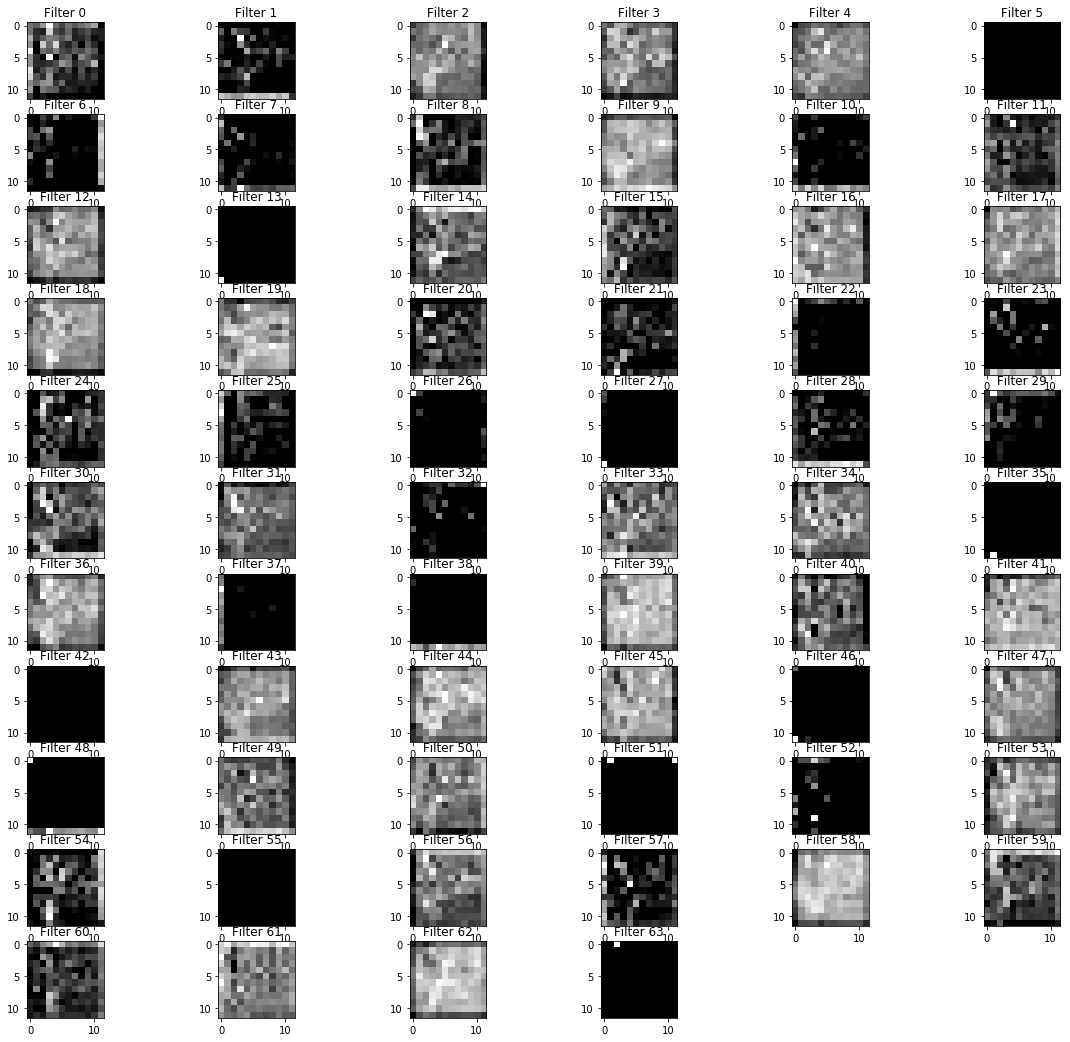

In [22]:
getActivations(sess2,pool1_cnn,images_test)

Confusion Matrix as numbers:
[ 0 10  0  0  0  0  0  0  0  0] (0) airplane
[0 6 0 0 0 0 0 0 0 0] (1) automobile
[0 8 0 0 0 0 0 0 0 0] (2) bird
[ 0 10  0  0  0  0  0  0  0  0] (3) cat
[0 7 0 0 0 0 0 0 0 0] (4) deer
[0 8 0 0 0 0 0 0 0 0] (5) dog
[ 0 16  0  0  0  0  0  0  0  0] (6) frog
[ 0 11  0  0  0  0  0  0  0  0] (7) horse
[ 0 13  0  0  0  0  0  0  0  0] (8) ship
[ 0 11  0  0  0  0  0  0  0  0] (9) truck
Plot Confusion Matrix:


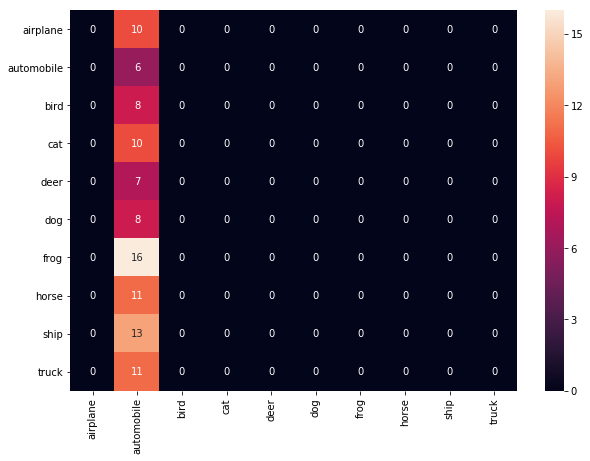

In [23]:
Test_Anlaysis(sess2,images_test, labels_test, cls_test[0:100])

## 5. Train the NIN Graph

In [26]:
now = datetime.now()

#dir_name = 'log_{0}_{1}'.format(now.month,now.day)
dir_name = './NIN/log_{0}_{1}'.format(now.month,now.day)
export_dir = './NIN/savedmodel_{0}_{1}_{2}_{3}'.format(now.month,now.day,now.hour,now.second)

img_size_cropped = 24
batch_size = 10
num_iterations = 100
print_unit = 100
opt_method = 'adam'

In [27]:
builder = tf.saved_model.builder.SavedModelBuilder(export_dir)
reset_default_graph()
with tf.Graph().as_default():
    
    global_step = tf.train.get_or_create_global_step()

    # Get images and labels for CIFAR-10.
    # Force input pipeline to CPU:0 to avoid operations sometimes ending up on
    # GPU and resulting in a slow down.
    
    with tf.device('/cpu:0'):
        # We build the model here as before
        x= tf.placeholder(tf.float32, shape=[None,32,32, num_channels], name='x')
        y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
        
        images = pre_process(images=x, training=True)
        
        with tf.name_scope('model'):
            logits,conv1,cccp1,cccp2,pool1,conv2,pool2,cccp3,cccp4,conv3,cccp5,cccp6,pool3 = compute_logits_NIN(images)

            print('conv1:',conv1.shape,
                  'cccp1:',cccp1.shape,
                  'cccp2:',cccp2.shape,
                  'pool1:',pool1.shape,
                  'conv2:',conv2.shape,
                  'pool2:',pool2.shape,
                  'conv3:',conv3.shape,
                  'cccp5:',cccp5.shape)
            
        with tf.name_scope('loss'):
            loss = compute_cross_entropy(logits=logits, y=y_true)
        with tf.name_scope('accuracy'):
            prediction,accuracy = compute_accuracy(logits=logits, y=y_true)
            
        
        with tf.name_scope('opt'):   
            if opt_method == 'sgd':
                opt = tf.train.GradientDescentOptimizer(0.5)
            elif opt_method == 'rms':
                opt = tf.train.RMSPropOptimizer(.001)
            elif opt_method == 'adam':
                opt = tf.train.AdamOptimizer(1e-4)
            train_step = opt.minimize(loss)
                
        with tf.name_scope('summaries'):
            # create summary for loss and accuracy
            tf.summary.scalar('loss', loss) 
            tf.summary.scalar('accuracy', accuracy)
            # create summary for logits
            tf.summary.histogram('logits', logits)
            # create summary for input image
            tf.summary.image('input', tf.reshape(images, [-1,img_size_cropped,img_size_cropped, num_channels]))
            summary_op = tf.summary.merge_all()
    
        saver = tf.train.Saver()    ##Save the model
        
        sess = tf.Session()
    
        summary_writer = tf.summary.FileWriter(dir_name, sess.graph)
        summary_writer_train = tf.summary.FileWriter(dir_name+'/train', sess.graph)
        summary_writer_val = tf.summary.FileWriter(dir_name+'/val')
    
        try:
            print("Trying to restore last checkpoint ...")

            # Use TensorFlow to find the latest checkpoint - if any.
            last_chk_path = tf.train.latest_checkpoint(checkpoint_dir='./NIN/model/')

            # Try and load the data in the checkpoint.
            saver.restore(sess, save_path=last_chk_path)

            # If we get to this point, the checkpoint was successfully loaded.
            print("Restored checkpoint from:", last_chk_path)
            
        except:
            # If the above failed for some reason, simply
            # initialize all the variables for the TensorFlow graph.
            print("Failed to restore checkpoint. Initializing variables instead.")
            sess.run(tf.global_variables_initializer())
    
        for i in range(num_iterations):
            X_batch, y_batch = random_batch()
            
            # now run
            _ , summary = sess.run((train_step, summary_op),
                                      feed_dict={x: X_batch, y_true: y_batch})
            
                
                # write the summary output to file
            if i%print_unit==0:
                
                summary_writer_train.add_summary(summary, i)                    
                (train_error,train_logits) = sess.run((accuracy,logits), {x: X_batch, y_true: y_batch})
                print("\rStep {0:3d}: training accuracy {1:0.4f}".forat(i, train_error), flush=True)
                
                X_batch2 = images_test
                y_batch2 = labels_test
                (val_error, summary) = sess.run((accuracy,summary_op), {x:X_batch2, y_true:y_batch2})
                print("\rStep {0:3d}: val accuracy {1:0.4f}".format(i, val_error), flush=True)
                
                summary_writer_val.add_summary(summary, i)
                saver.save(sess, './NIN/model/model_iter', global_step=i)
                
        # Save the final model
        save_path = saver.save(sess, "./NIN/model/model.ckpt")
        builder.add_meta_graph_and_variables(sess,["foo-tag"])
builder.save()

conv1: (?, 24, 24, 192) cccp1: (?, 24, 24, 160) cccp2: (?, 24, 24, 96) pool1: (?, 12, 12, 96) conv2: (?, 12, 12, 192) pool2: (?, 6, 6, 192) conv3: (?, 6, 6, 192) cccp5: (?, 6, 6, 192)


<tf.Tensor 'summaries/loss:0' shape=() dtype=string>

<tf.Tensor 'summaries/accuracy:0' shape=() dtype=string>

<tf.Tensor 'summaries/logits:0' shape=() dtype=string>

<tf.Tensor 'summaries/input:0' shape=() dtype=string>

Step   0: training accuracy 0.1000
Step   0: val accuracy 0.1000


'./model/model_iter-0'

INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: b'./NIN/savedmodel_12_14_14_29\\saved_model.pb'


b'./NIN/savedmodel_12_14_14_29\\saved_model.pb'

## 6. Evaluate the CNN Graph

### 1. Show the shape of different layers

In [28]:
conv1,cccp1,cccp2,pool1,conv2,pool2,cccp3,cccp4,conv3,cccp5,cccp6,pool3

(<tf.Tensor 'model/Relu:0' shape=(?, 24, 24, 192) dtype=float32>,
 <tf.Tensor 'model/Relu_1:0' shape=(?, 24, 24, 160) dtype=float32>,
 <tf.Tensor 'model/Relu_2:0' shape=(?, 24, 24, 96) dtype=float32>,
 <tf.Tensor 'model/MaxPool:0' shape=(?, 12, 12, 96) dtype=float32>,
 <tf.Tensor 'model/Relu_3:0' shape=(?, 12, 12, 192) dtype=float32>,
 <tf.Tensor 'model/AvgPool:0' shape=(?, 6, 6, 192) dtype=float32>,
 <tf.Tensor 'model/Relu_4:0' shape=(?, 12, 12, 192) dtype=float32>,
 <tf.Tensor 'model/Relu_5:0' shape=(?, 12, 12, 192) dtype=float32>,
 <tf.Tensor 'model/Relu_6:0' shape=(?, 6, 6, 192) dtype=float32>,
 <tf.Tensor 'model/Relu_7:0' shape=(?, 6, 6, 192) dtype=float32>,
 <tf.Tensor 'model/Relu_8:0' shape=(?, 6, 6, 10) dtype=float32>,
 <tf.Tensor 'model/AvgPool_1:0' shape=(?, 1, 1, 10) dtype=float32>)

### 2. Visualize the Conv Layers

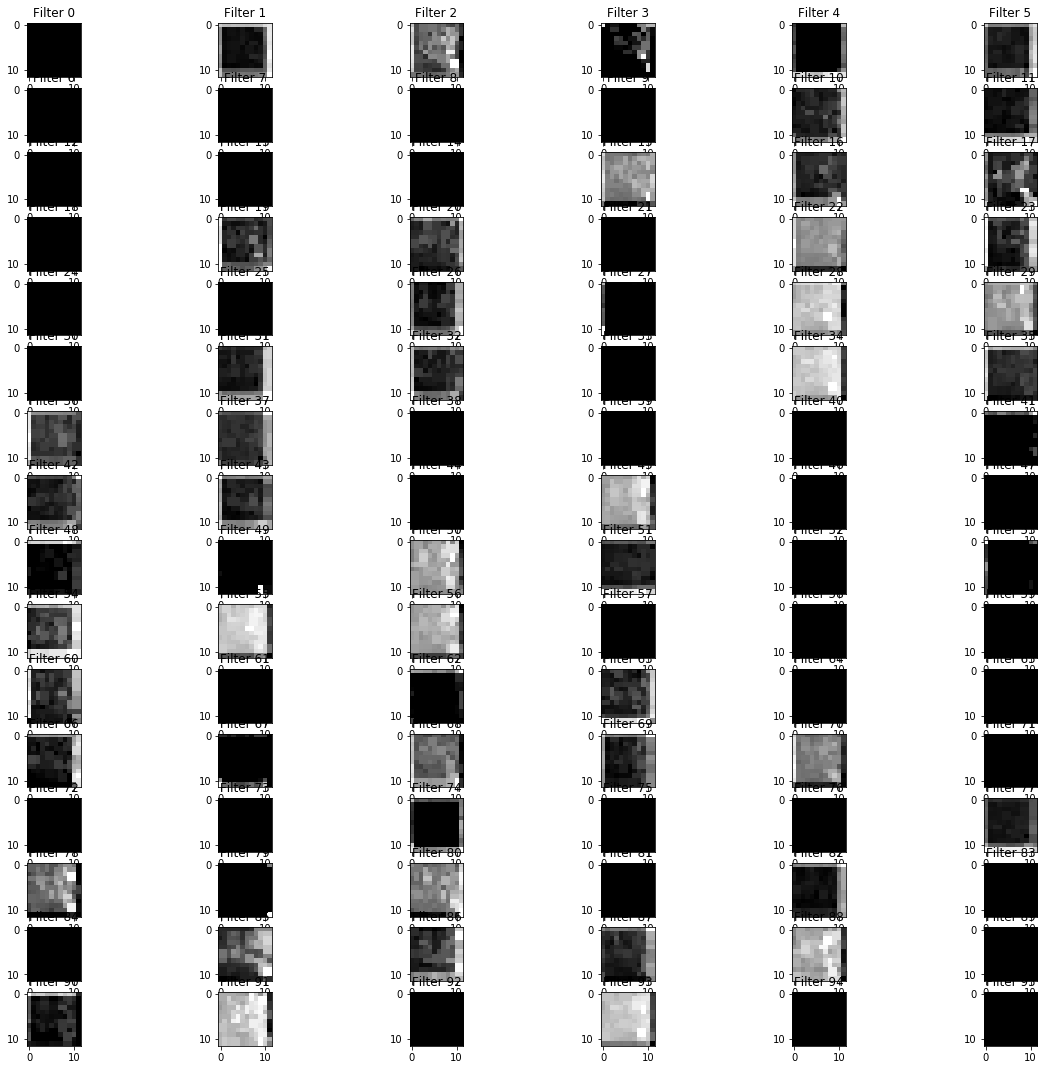

In [29]:
getActivations(sess,pool1,images_test)

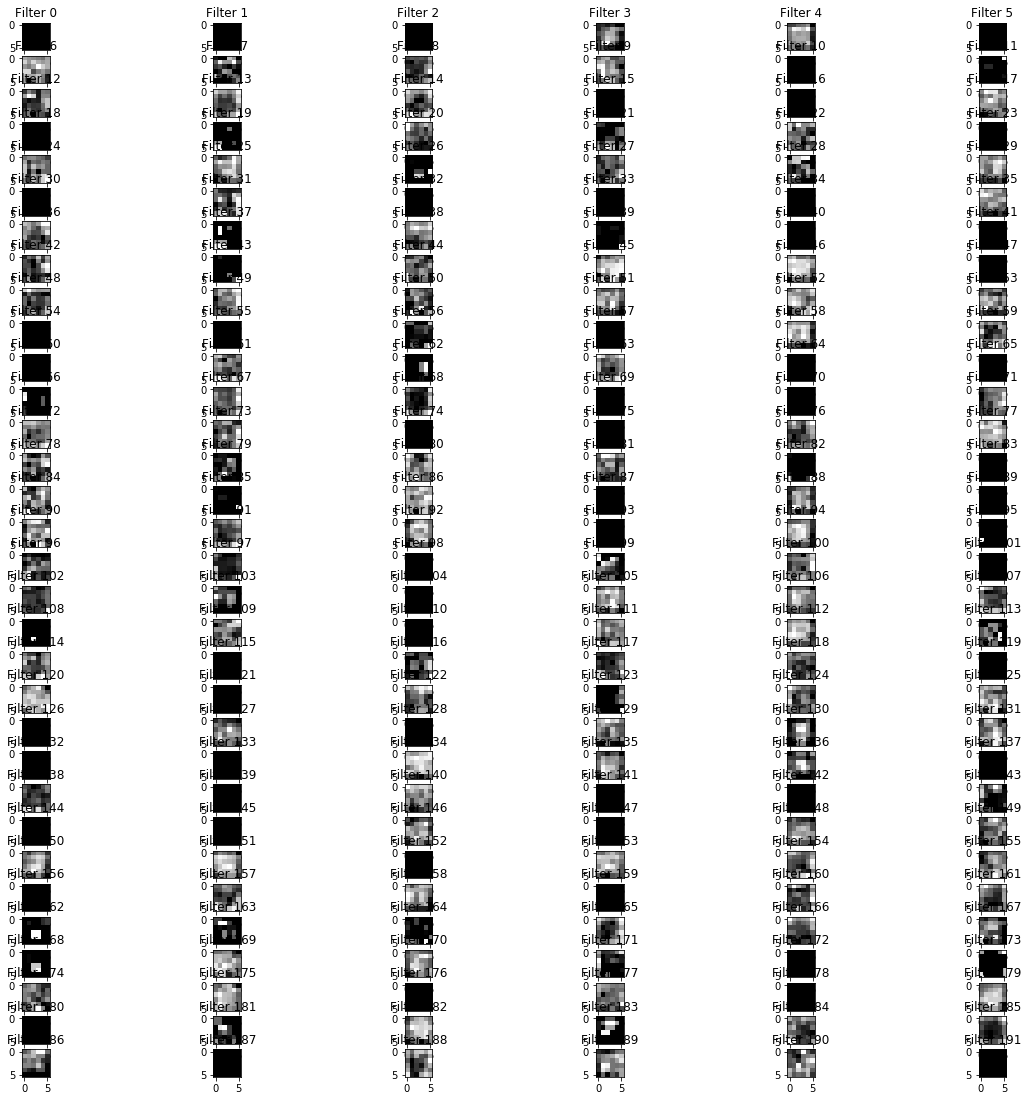

In [30]:
getActivations(sess,pool2,images_test)

### 3. Plot the confusion Matrix

Confusion Matrix as numbers:
[ 0 10  0  0  0  0  0  0  0  0] (0) airplane
[0 6 0 0 0 0 0 0 0 0] (1) automobile
[0 8 0 0 0 0 0 0 0 0] (2) bird
[ 0 10  0  0  0  0  0  0  0  0] (3) cat
[0 7 0 0 0 0 0 0 0 0] (4) deer
[0 8 0 0 0 0 0 0 0 0] (5) dog
[ 0 16  0  0  0  0  0  0  0  0] (6) frog
[ 0 11  0  0  0  0  0  0  0  0] (7) horse
[ 0 13  0  0  0  0  0  0  0  0] (8) ship
[ 0 11  0  0  0  0  0  0  0  0] (9) truck
Plot Confusion Matrix:


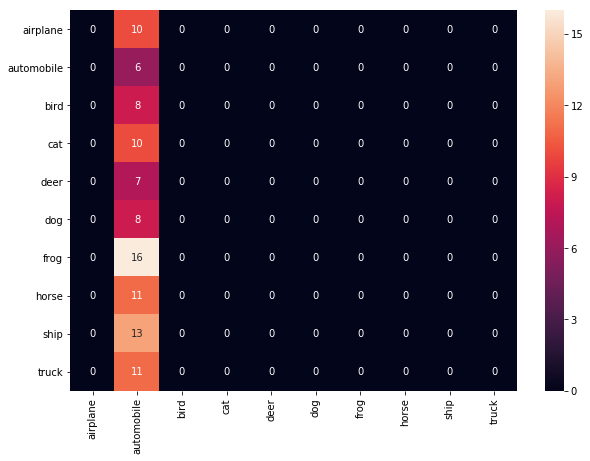

In [65]:
Test_Anlaysis(sess,images_test, labels_test, cls_test[0:100])